## Data Preparing

Firstly, we import some libraries that we will use to work with data.

In [43]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [30]:
import nltk
from nltk.stem.snowball import SnowballStemmer
import string

## Transform Data to DataFrames
On first stage of our work we organize text files to more convinient form like data frames (using Pandas library) and save them to csv files. 

In addition, we transform text data  from reviews using stemming (from NLTK library) methods.

In [31]:
def stemText(row):
    source = row["text"]
    
    text_string = "".join(l for l in source if l not in string.punctuation)
    
    stemmer = SnowballStemmer("english")       
    words = text_string.split(" ")
        
    new_words = []
        
    for i in range(len(words)):
        if words[i] != "" and words[i] != " ":
            new_words.append(stemmer.stem(words[i].strip()))

    text_string = " ".join(l for l in new_words)
    
    return text_string

In [66]:
base_data_path = 'C://Work/DataScience/Data/aclImdb/'

pos_data_folder_path_template = base_data_path + '{0}/pos/'
neg_data_folder_path_template = base_data_path + '{0}/neg/'

for data_purpose_label in ['train', 'test']:
    data = []
    folderPath_array = [neg_data_folder_path_template, pos_data_folder_path_template]
    
    for folder_path_index in range(2):
        counter = 0
        for fileName in os.listdir(folderPath_array[folder_path_index].format(data_purpose_label)):        
            with open(folderPath_array[folder_path_index].format(data_purpose_label) + fileName, 'r', 
                        encoding='utf-8') as review_file:
                txt = review_file.read()            
                data.append([txt, folder_path_index])            
    
    df = pd.DataFrame(data, columns=['text', 'neg_pos'])
    df['textStem'] = df.apply(stemText, axis=1, raw=False)
    import csv
    df[["neg_pos","textStem"]].to_csv("dataframe_stem_{0}.csv".format(data_purpose_label), index=False, 
                                      quoting=csv.QUOTE_NONNUMERIC)    

## Model

Load prepared data from CSV files.

In [67]:
df_train = pd.read_csv('dataframe_stem_train.csv')
df_test = pd.read_csv('dataframe_stem_test.csv')

df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

features_train = df_train['textStem']
features_test = df_test['textStem']

labels_train = df_train['neg_pos']
labels_test = df_test['neg_pos']


### Vectorize Text Data

Let's use text vectorization procedure. This presentation of source data allow us to apply some machine learning models.

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.999, stop_words='english')                
features_train_transformed = vectorizer.fit_transform(features_train)
features_test_transformed  = vectorizer.transform(features_test)
print(features_train_transformed.shape)

(25000, 91805)


### Select Percentile

As a result of a previous step, we get data table with 90K+ columns. It's a quite big data piece and we can face computer resources related troubles during processing such amount of data. So, we will use SelectPercentile method to reduce data dimensions. Using this approach, we can easly manipulate data size to test our models.

In [69]:
percentile_value = 20
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=percentile_value)
selector.fit(features_train_transformed, labels_train)
features_train_transformed_q = selector.transform(features_train_transformed).toarray()
features_test_transformed_q  = selector.transform(features_test_transformed).toarray()

print(features_train_transformed_q.shape)

(25000, 18361)


### Gaussian (Naive Bayes)

We start with Gaussian Naive Bayes Classifier. We are going to check if it's a good idea to classify movie reviews using conditional probability approach (Bayesian theorem).

In [40]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train_transformed_q, labels_train)


GaussianNB(priors=None, var_smoothing=1e-09)

In [41]:
pred = clf.predict(features_test_transformed_q)

sc = clf.score(features_test_transformed_q, labels_test)               
print("Gaussian = ", sc)

Gaussian =  0.5782


Gaussian Naive Bayes Classifier gives us an accuracy about 60% which as just a little bit better that base random approach (random labeling, 50/50).

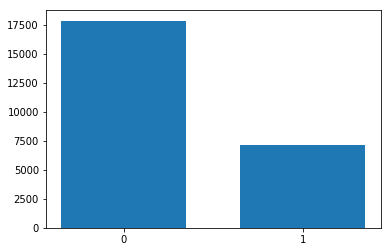

In [71]:
import collections

labels, values = zip(*sorted(collections.Counter(pred).items()))

indexes = np.arange(len(labels))
width = 0.7

plt.bar(indexes, values, width)
plt.xticks( labels)
plt.show()


Also we can see that Gaussian Classifier tends to classify more negative reviews.

### Linear Classifier (Logistic Regression)

Next model that we are going to use is Linear Classifier (Logistic Regression). This model is even worse than Gaussian (accuracy near 50%).

In [73]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()

log_model = log_model.fit(X=features_train_transformed, y=labels_train)
y_pred = log_model.predict(features_test_transformed)

from sklearn.metrics import accuracy_score
print(accuracy_score(labels_train, y_pred))

0.49608


# Keras

Next step is using deep learning with Keras and Tensorflow libraries.

### Vectorize labels

In [74]:
y_train = np.array(labels_train).astype('float32')
y_test = np.array(labels_test).astype('float32')

### Prepare validation data

In [75]:
validation_data_count = 5000
train_data_count = features_train_transformed_q.shape[0] - validation_data_count

x_val = features_train_transformed_q[:validation_data_count]
x_train_partial =  features_train_transformed_q[validation_data_count:]

y_val = y_train[:validation_data_count]
y_train_partial = y_train[validation_data_count:]



In [76]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(x_train_partial.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc']
             )

In [77]:
history = model.fit(x_train_partial, y_train_partial, epochs=10, batch_size=512, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 8s 411us/step - loss: 0.6497 - acc: 0.8010 - val_loss: 0.5997 - val_acc: 0.8738
Epoch 2/10
20000/20000 [==============================] - 5s 227us/step - loss: 0.5393 - acc: 0.8833 - val_loss: 0.4863 - val_acc: 0.8818
Epoch 3/10
20000/20000 [==============================] - 4s 205us/step - loss: 0.4181 - acc: 0.9021 - val_loss: 0.3826 - val_acc: 0.8858
Epoch 4/10
20000/20000 [==============================] - 4s 207us/step - loss: 0.3179 - acc: 0.9143 - val_loss: 0.3066 - val_acc: 0.8956
Epoch 5/10
20000/20000 [==============================] - 4s 206us/step - loss: 0.2457 - acc: 0.9261 - val_loss: 0.2611 - val_acc: 0.9066
Epoch 6/10
20000/20000 [==============================] - 4s 207us/step - loss: 0.1982 - acc: 0.9358 - val_loss: 0.2324 - val_acc: 0.9086
Epoch 7/10
20000/20000 [==============================] - 4s 206us/step - loss: 0.1657 - acc: 0.9442 - val_loss: 0.2184 - v

In [78]:
results = model.evaluate( features_test_transformed_q, y_test)
print(results)

25000/25000 [==============================] - 13s 508us/step
[0.3201426215195656, 0.86836]


After checking our model on test data, we can see that deep learning approcah shows us an accuracy about 86%. This result is much better than previous models.

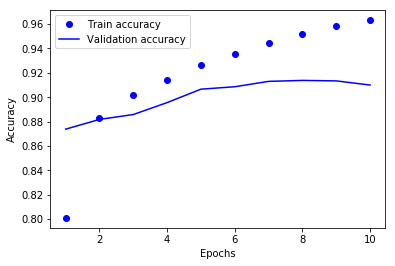

In [80]:
plt.clf()

acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

But we can see that our model start showing overfitting signs after 5-7 epochs.

## L2 Regularization

We will use L2 regularization to try to avoid overfitting in our model.

In [81]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(x_train_partial.shape[1],)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc']
             )

In [82]:
history = model.fit(x_train_partial, y_train_partial, epochs=10, batch_size=512, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 621us/step - loss: 0.7017 - acc: 0.6948 - val_loss: 0.6651 - val_acc: 0.6904
Epoch 2/10
20000/20000 [==============================] - 5s 247us/step - loss: 0.6343 - acc: 0.7860 - val_loss: 0.6033 - val_acc: 0.8358
Epoch 3/10
20000/20000 [==============================] - 5s 239us/step - loss: 0.5677 - acc: 0.8524 - val_loss: 0.5427 - val_acc: 0.8764
Epoch 4/10
20000/20000 [==============================] - 5s 226us/step - loss: 0.5013 - acc: 0.8859 - val_loss: 0.4821 - val_acc: 0.8848
Epoch 5/10
20000/20000 [==============================] - 5s 235us/step - loss: 0.4378 - acc: 0.9024 - val_loss: 0.4281 - val_acc: 0.8844
Epoch 6/10
20000/20000 [==============================] - 5s 234us/step - loss: 0.3864 - acc: 0.9104 - val_loss: 0.3929 - val_acc: 0.8878
Epoch 7/10
20000/20000 [==============================] - 5s 234us/step - loss: 0.3504 - acc: 0.9148 - val_loss: 0.3700 - 

In [83]:
results = model.evaluate( features_test_transformed_q, y_test)
print(results)

25000/25000 [==============================] - 13s 534us/step
[0.38558057859420775, 0.8752]


Accuracy 87%

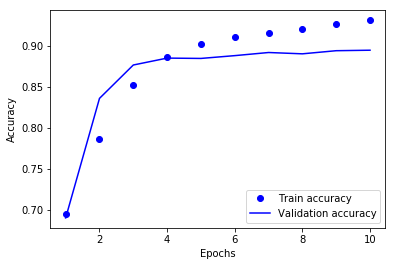

In [84]:
import matplotlib.pyplot as plt

plt.clf()

acc_values = history.history['acc']
val_acc_values = history.history['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The chart shows us that L2 regularization was a quite effective to fight overfitting.